# Example 2: Pairwise offset from Reference to Target star

This example shows how to use lowfssim to model the sensing offsets (errors) caused by moving between the reference and target stars, which have different spectral types, brightnesses, and for which we use different EM gains.  It showcases:

- using the integrated detector model
- interweaving of multiple model "states" simultaneously

Note that the EM gains in this example are notional, and should not be taken as a form of gospel for CGI.

In [29]:
%load_ext autoreload
%autoreload 2

# this import block isn't any of the good stuff

from pathlib import Path

from lowfsc import props
from lowfsc.data import DesignData
from lowfsc.spectral import StellarDatabase, ThroughputDatabase, LOWFS_BANDPASS
from lowfsc.reconstruction import Reconstructor, synthesize_pupil_shear, prepare_Zmm, vmag_normalize
from lowfsc.emccd import EMCCD
from lowfsc.automate import chop_bipolar, plot_modes

import numpy as truenp

from tqdm import tqdm

from prysm.conf import config
from prysm.fttools import mdft

import cupy as cp
from cupyx.scipy import fft as cpfft

from prysm.mathops import np, fft

from matplotlib import pyplot as plt

mdft.clear()
fft._srcmodule = cpfft
np._srcmodule = cp
config.precision = 32

plt.style.use('bmh')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# note that this is a little bit different
root = Path('~/src/lowfssim-public/data').expanduser()


star_type1 = 'g0v'
star_type2 = 'b3v'
wvl = LOWFS_BANDPASS

mode='hlc' # or spec or wfov
dd = DesignData.hlc_design(root)
sd = StellarDatabase.bijan_data(root)
td = ThroughputDatabase.bijan_data(root)

throughput = td(mode, wvl)

weightsRef = sd(star_type1, wvl)
weightsTarg = sd(star_type2, wvl)
fudgeRef = sd.sparsity_fudge_factor(star_type1, wvl)
fudgeTarg = sd.sparsity_fudge_factor(star_type2, wvl)

# the reference star is magnitude 2.25, the target magnitude 5
vRef = 10 ** (-2.25/2.5)
vTarg = 10 ** (-2.25/2.5)
weightsRef = weightsRef * (fudgeRef*vRef*throughput)
weightsTarg = weightsTarg * (fudgeTarg*vTarg*throughput)

GAINREF = 20
GAINTARG = 150
cam = EMCCD.cgi_camera()
cam.em_gain = GAINREF


dd.seed_zernikes(range(2,12))
wt = np.zeros(10)

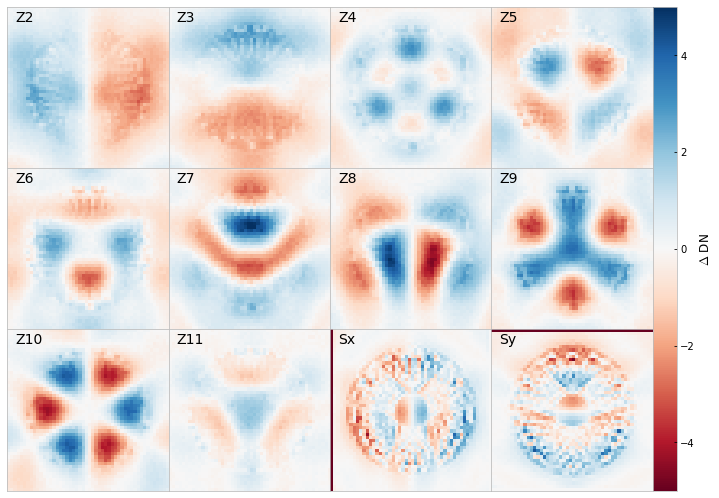

In [34]:
# in the cgi conops, we do chopping on the brighter reference star and adjust the estimator for the target star
CHOPSIZE = 5
# this is a "more clever" way of doing the same thing as the lowfssim manual
chops = np.diag(np.ones_like(wt)*CHOPSIZE)
ref_z = np.zeros_like(wt)
ref_z[0] = 3.14  # assume we didn't do an ideal (perfect) job aligning the occulter;
ref_z[1] = 2.87

average_frame_10s = lambda img: cam.expose(img, 10_000).mean(axis=0, dtype=cp.float32)

cam.em_gain = GAINREF
diffs, ups, downs = chop_bipolar(wvl, weightsRef, dd, ref_z, chops, cam=cam) # note difference from ex1
for diff in diffs:
    diff /= CHOPSIZE
    
ref = props.polychromatic(wvl, weightsRef, dd, ref_z)
dark = cp.zeros_like(ref)  # dark field to expose


refRef = average_frame_10s(ref)
darkRef = average_frame_10s(dark)

cam.em_gain = GAINTARG

# here we assume there is no change in alignment between ref and target for simplicity
ref2 = props.polychromatic(wvl, weightsTarg, dd, ref_z)
refTarg = average_frame_10s(ref2)
darkTarg = average_frame_10s(dark)

darksubRef = refRef - darkRef
darksubTarg = refTarg - darkTarg

chop_shear_px = 0.038
sy = synthesize_pupil_shear(darksubRef, chop_shear_px, 0)
sx = synthesize_pupil_shear(darksubRef, chop_shear_px, 1)
sy /= chop_shear_px
sx /= chop_shear_px

sy2 = synthesize_pupil_shear(darksubTarg, chop_shear_px, 0)
sx2 = synthesize_pupil_shear(darksubTarg, chop_shear_px, 1)
sy2 /= chop_shear_px
sx2 /= chop_shear_px

mask = np.ones_like(ref)
mask[0,:] = 0
mask[-1,:] = 0
mask[:,0] = 0
mask[:,-1] = 0

zmm = prepare_Zmm(diffs, darksubRef, (sx,sy), mask)
zmm2 = vmag_normalize(zmm, darksubRef, darksubTarg, sx2, sy2, mask)
RRef = Reconstructor(zmm, refRef, darkRef)
RTarg = Reconstructor(zmm2, refTarg, darkTarg)

plot_modes(diffs, sx, sy, clim=5);

In [25]:
# check that the reference star reconstructor recognizes the chops
RRef.estimate(ups[0])[1]

array(5., dtype=float32)

In [28]:
# now we poke each mode on the target star and see the difference in response
wt[:] = 0
estimates = []
cam.em_gain = GAINTARG
for i, chop in enumerate(chops):
    wt[i] = CHOPSIZE
    im = props.polychromatic(wvl, weightsTarg, dd, ref_z+wt)
    im = average_frame_10s(im)
    est = RTarg.estimate(im)
    estimates.append(est)

# crop out the Zernike estimates and take the diagonals
raw_estimates = cp.array(estimates)
estimates = cp.diag(raw_estimates[:,1:11])

truenp.set_printoptions(suppress=True, precision=3)

print(cp.diag(chops))
print(estimates)

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[5.044 5.02  5.022 4.893 5.005 5.084 4.927 5.113 4.823 6.924]


we can see that the estimator has nearly unit gain for most modes, even after accomidation for a different stellar type, flux, and EM gain